# Import Packages and Functions

In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys  
# !{sys.executable} -m pip install wordcloud
# from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score , confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(filename)

2.5.0


In [2]:
# Use the the path of the .csv file, that I have attached along with the code
tweets_train_dataset=pd.read_csv("C:/Users/Ajay/Desktop/Hatespeech/FinalDataset_Train1.csv")
# tweets_train_dataset
tweets_test_dataset=pd.read_csv("C:/Users/Ajay/Desktop/Hatespeech/FinalDataset_Test1.csv")
tweets_test_dataset

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,label,tweet
0,46745,26678,26678,0,resistance. #job #ruiva #cacheada
1,46746,33358,33358,1,&#8220;@M_Rad: I'm going to miss these bitches...
2,46747,6249,6249,0,ð #tech bitcoin vs. gold [infographic]
3,46748,49095,49095,1,RT @Ronesha__: When I feel like he entertainin...
4,46749,55583,55583,1,bitch betta get it right...shout out....ddaaaw...
...,...,...,...,...,...
9995,56740,17227,17227,0,"@user so we've been here since 9, requested 4 ..."
9996,56741,23832,23832,0,- sirf ashiq log follow karen #iqbal #galib #w...
9997,56742,9846,9846,0,what is a #detoxdiet? #altwaystoheal! #health...
9998,56743,55726,55726,0,dodgerofzion asked: A giant green rooster walk...


In [3]:
x = tweets_train_dataset['tweet']
y = tweets_train_dataset['label']

In [4]:
tweets_train_dataset['label'].value_counts()

0    26853
1    19892
Name: label, dtype: int64

In [5]:
max_features = 20000
max_text_length = 400

In [6]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))

In [7]:
# Save tokenizer for future use
with open('toxic_tokenizer.pkl', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

# Vectorizing using Glove vectorizer 

In [9]:
embedding_dim =100
embeddings_index = dict()
f = open('C:/Users/Ajay/Desktop/Hatespeech/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [10]:
embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

In [11]:
filters= 250
kernel_size=3
hidden_dims= 250

# Building a CNN model

In [12]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

In [13]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y,test_size=0.2,random_state=1)

# Training the CNN Model

In [15]:
batch_size= 32
epochs = 5
hist = model.fit(x_train,y_train,
                    batch_size= batch_size,
                    epochs=epochs,
                    validation_data= (x_val,y_val)
                    )

Epoch 1/5
1169/1169 [==============================] - 180s 152ms/step - loss: 0.2645 - accuracy: 0.8907 - val_loss: 0.1934 - val_accuracy: 0.9201
Epoch 2/5
1169/1169 [==============================] - 180s 154ms/step - loss: 0.2015 - accuracy: 0.9192 - val_loss: 0.1920 - val_accuracy: 0.9260
Epoch 3/5
1169/1169 [==============================] - 178s 152ms/step - loss: 0.1783 - accuracy: 0.9283 - val_loss: 0.1746 - val_accuracy: 0.9324
Epoch 4/5
1169/1169 [==============================] - 173s 148ms/step - loss: 0.1549 - accuracy: 0.9391 - val_loss: 0.1786 - val_accuracy: 0.9323
Epoch 5/5
1169/1169 [==============================] - 169s 144ms/step - loss: 0.1354 - accuracy: 0.9462 - val_loss: 0.1860 - val_accuracy: 0.9345


In [16]:
x_test = tweets_test_dataset['tweet'].values
y_test = tweets_test_dataset['label'].values

In [17]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized,maxlen=max_text_length)

In [18]:
y_pred = model.predict(x_testing,verbose=1,batch_size=32)

313/313 [==============================] - 12s 38ms/step


In [19]:
y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]

In [20]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy: 93.01%


In [21]:
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred, average='macro')))

F1 Score: 0.927884


In [22]:
print("F1 Score: {:.6f}".format(precision_score(y_test, y_pred, average='macro')))

F1 Score: 0.932918


In [23]:
print("F1 Score: {:.6f}".format(recall_score(y_test, y_pred, average='macro')))

F1 Score: 0.924384


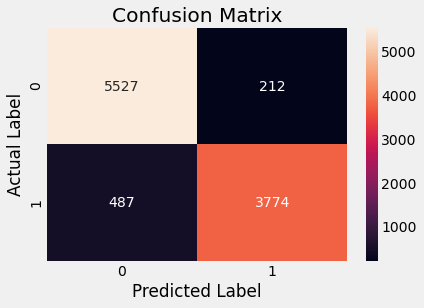

In [24]:
cm = confusion_matrix(y_test, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show(fig)